# Open Addressing HashMaps

I recently stumbled across the wild world of hashmaps when I was writing a chapter about how dictionaries are implemented in Python and fell down a pretty deep rabbit hole. Intruiged, I set out to determine whether I myself could write a hashmap faster that would rival or potentially even surpass the performance of *std::unordered_map*.

## The Operations

When implementing my hashmaps, I focused on 3 main functions:

1. **void insert(K& const key, V& const value)**: Takes a key and a value and inserts a new pair into the hashmap

2. **bool emplace(K const &key, V &value)**: Takes a key and a value variable and queries the hashmap. If the value does exist, the function writes the corresponding value to the given value variable and returns true. If the value doesn't exist, then the function returns false.

3. **bool remove(K const &key)**: Takes a key and queries the hashmap. If the value exists, then the hashmap removes the entry and the function returns true. If the value doesn't exist, then the function returns false.

I refer to emplace and look-ups interchangeably, since they're essentially the same thing, except emplace as a function is easier to debug.

## Worst-Case vs. Average-Case

Hashmaps are known to have $O(N)$ worst case complexities, since it's easy to construct a malicious test case that causes a hashmap to look through all of the entries in the map. What's more interesting is the average worst-case performance. When I use Big-O notation in this article, it will refer to average worst-case performance. What I mean by average worst-case performance is we'll look at worst-cases for each function assuming perfectly randomly uniform hashes. The great thing about average-case performance is that you can use expected value for calculations.



## std::unordered_map

### The Implementation
*std::unordered_map* uses a technique called separate chaining to build its hashmap. You can think of the underlying structure of *std::unordered_map* as a static array with buckets of linked lists that hold key-value pairs. When a new key-value pair needs to be inserted into the hashmap, *std::unordered_map* takes the key, hashes it, and converts the hash into an index. *std::unordered_map* then goes to its table, finds the index, and checks whether a key or keys already live there. If the index is empty, then the table simply inserts the key-value pair. However, if there are multiple keys, then *std::unordered_map* will check all of the keys that live there already to determine if the key already exists. If it does, then it only changes the value. If it doesn't, then *std::unordered_map* will insert the new key-value pair into a chain of other key-value pairs in the form of a linked-list. When a key-value pair needs to be removed, the map iterates over that bucket's linked list and splices out the key-value pair if it is found.

### Theoretical Performance

#### Average-Case Behavior

Let the total number of buckets (i.e the capacity of the hashmap) be $K$ and let the total number of entries be $N$. Suppose we assume our hash function has a perfectly uniform distribution. That is, suppose that for every possible object, the probability of it hashing to any bucket is the same. Then the probability that an object hashes to a bucket $i$ is $\frac{1}{K}$ and the expected number of entries per bucket is $N \cdot \frac{1}{K} = \frac{N}{K}$.

When we insert, we first have to search every single value in the bucket, so the average-case performance is $O\left(\frac{N}{K}\right)$. This seems like it's linear, but we can say it's amortized O(1) if $\frac{N}{K} \approx C$, where $C$ is some constant. Thus, we can achieve amortized O(1) when $N \approx CK$, which can be maintained by rehashing and expanding the number of buckets to compensate when $N$ gets too high. The time complexity for look-ups and removals is very similar.

#### Issues with Chaining
Chaining is a very simple method to ensure that keys are safely kept in the bucket they're assigned to. In addition, since we can grow the linked list to infinite length, technically we can never run out of space in our hashmap. The static array does not need to be grown. However, this does come with some significant drawbacks. In the case that elements are mapped to a small range of indices, there's a lot of wasted space in the hashmap. Cache performance is also not great with linked lists, since linked list nodes are not (necessarily) adjacent in memory. As you iterate along the chain, you run into a bunch of cache misses bouncing across memory addresses, which slows down search.

Our goal is to minimize wasted space and improve cache performance of searches with the following hashmap implementations.

## LinearMap

### The Implementation

The first hashmap I implemented uses open addressing with linear probing, which I called LinearMap. The idea of open addressing is that key-value pairs can live in slots that it does not necessarily map to. The underlying structure is an array of objects of type `Entry<K, V>`. Each entry stores the key, the value, the hash value of the key, and some other book keeping items. Suppose you want to insert a key-value pair, and the key hashes to index 21. But in index 21, there already exists a key-value pair. Instead of chaining, what we do is we "probe" for an empty slot and stick it in there instead. When we want to look-up a value, we go to the initial bucket that the key hashes to and check if that slot contains the key. If the slot doesn't, then we continue to probe the same way we did looking for an empty slot. 

Normally, I've seen resources online use tombstones when implementing pure linear open-addressed hashmaps. Tombstones are markers that denote entries that have been used but are now empty since the key value pair has been removed. This makes removals super easy since you just mark them as a tombstone and get on with your day. When you insert values into the hashmap, you can insert them into tombstones. However, when you look up values, you have to skip over tombstones and keep looking because if you stop when you get to a tombstone, there's the possibility that a key that you had added after the deleted key can no longer be reached when probing from the start index.

### Theoretical Performance

#### Average Case Performance

However, like I said, we deal with average-case complexity. To talk about performance with open-addressed maps, we introduce the idea of a probe sequence length, or PSL. The probe sequence length is how far in terms of slots you have to probe starting from the index that a key originally hashes to in order to get to the key in question. 

In order to calculate the average PSL of a linear hashmap, let's first analyze the average case performance of insertions. The worst case for an insertion is where the key is new to the hashmap, since it has to look through the entire probe sequence. Let $K$ be the number of slots in the hashmap, $N$ be the number of key-value pairs, and $T$ be the number of tombstones. Under the assumption of a perfectly random hash function, each entry in the array has a probability $\frac{N}{K}$ of being occupied by a key-value pair, a probability $\frac{T}{K}$ of being a tombstone, and a probability $\frac{K - \left(N+T\right)}{K}$ probability of being completely empty. The average PSL can then be calculated as the expected number of contiguous slots that aren't empty. This follows a geometric distribution, parametrized by the probability of finding an empty slot, $\frac{K - \left(N+T\right)}{K}$, giving an expected PSL of $\frac{K}{K - \left(N+T\right)}$. With the backwards shifting method, the number of tombstones is zero, giving an expected PSL of $\frac{K}{K - N}$.

We can now describe the performance of look-ups and removals in terms of PSLs. Since unsuccessful look-ups have to look through the entire probe sequence as well, we can say that the average worst-case performance is $O\left(\frac{K}{K - \left(N+T\right)}\right)$. For removals, if we use the tomb-stone method, then the average worst-case performance is $O\left(\frac{K}{K - \left(N+T\right)}\right)$ as well. If we use the backwards shift method, then the worst-case performance is when we have to swap the entire probe sequence backwards. However, with backwards shifting, there doesn't exist any tombstones, so $T = 0$ yielding an average worst-case performance is actually $O\left(\frac{K}{K - N}\right)$.

#### Pros and Cons of Open Addressing

Since all of the entries are placed next to one another in a flat array, this means that cache performance should be better. However, with tombstones, it's possible that interleaving insertions and removals results in longer probe sequences the linked list would have, as mentioned above. According to this [stackoverflow post](https://stackoverflow.com/questions/47781316/linked-list-vs-array-traversal-efficiency), following pointer indirection takes 4 times as many cycles as calculating the next address in an array. 

Under the assumption of a perfectly uniform hashmap, we previously calculated that there would be average of $\frac{N}{K}$ entries in a list. The worst-case scenario would be having to follow every single entry in an unsuccessful look-up. We can calculate when the performance of separate chaining is worse than the performance of open addressing as follows:

$$\begin*{gather}4\frac{N}{K} > \frac{K}{K - N} \\ \end*{gather}$$


## Robinhood Map

## Benchmark Results

First, we run the benchmark speed and memory usage tests and load in the CSV files:

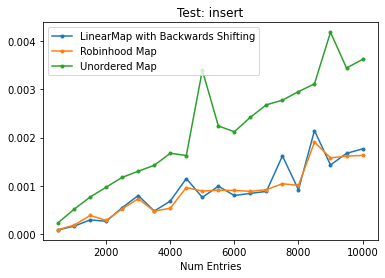

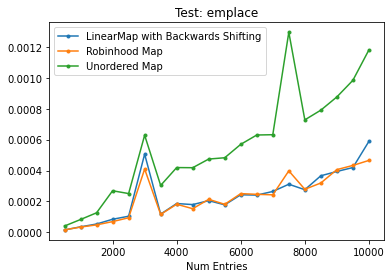

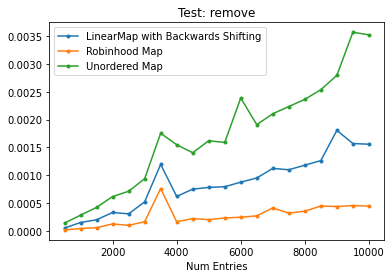

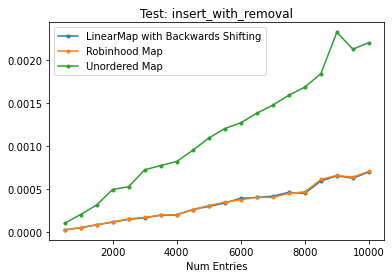

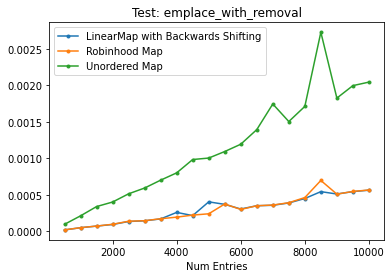

In [22]:
benchmarks_dir = './benchmarks/'
benchmark_names = ['insert', 'emplace', 'remove', 'insert_with_removal', 'emplace_with_removal']
hashmap_names = ['LinearMap with Tombstone','LinearMap with Backwards Shifting','Robinhood Map','Unordered Map']
hashmap_names = ['LinearMap with Backwards Shifting','Robinhood Map','Unordered Map']

pds = {}

for name in benchmark_names:
    new_df = pd.read_csv(benchmarks_dir + name + '.csv')
    pds[name] = new_df

for name in benchmark_names:
    pds[name].plot(x = 'Num Entries', y = hashmap_names, title = "Test: {}".format(name), style='.-')
    

### Simple Insertion

This test generates a vector of keys from 0 to $K$, shuffles them into a random order, then records the time it takes to insert all of the keys into the hashmap.

### Simple Look-Up

This test generates a vector of keys from 0 to $K$, shuffles them into a random order, and then inserts the keys into the hashmap. Then it shuffles the keys into a random order again and records the time it takes to look up all of the keys in the vector.

### Simple Removal

This test generates a vector of keys from 0 to $K$, shuffles them into a random order, then inserts the keys into the hashmap. Then it shuffles the keys into a random order again and records the time it takes to remove all of the keys in the vector.

### Insertions with Removals

This test generates a vector of keys from 0 to $K$, shuffles them into a random order, then inserts the keys into the hashmap. Then it shuffles half of the randomized keys into a random order again and removes those keys from the hashmap. Finally, all the keys are shuffled into a random order and the test records the time it takes to insert all of the keys in the vector.

### Look-Ups with Removals

This test generates a vector of keys from 0 to $K$, shuffles them into a random order, then inserts the keys into the hashmap. Then it shuffles half of the randomized keys into a random order again and removes those keys from the hashmap. Finally, all the keys are shuffled into a random order and the test records the time it takes to look-up all of the keys in the vector.